# LSTM Neural Network Implemented with `edf`

This Recurrent network learns from [Shakespear's Coriolanus](./input.txt). 

This LSTM implementation is similar to the [vanilla RNN (cleaned up)](../002_vanila_RNN_with_edf/vanilla_RNN_cleaned_up.ipynb) in the setup. The LSTM cell is used as following

```python

lstm = LSTM(params)

for t in range(len(input_string)):

    h[t+1], y[t] = rnn.chain(h[t], x[t])

    loss = loss + Dot@{Softmax(y[t]), targets[t]}

```

The weights overflows during backprop if the learning rate is too high or if the training set is long. This is consistent with the literature, and a sensible solution is to clip the gradient during learning. No such gradient clipping is implemented here.

Compared with vanilla RNN, LSTM learns faster and is more stable. 

Some care was taken to initialize the charater to vector (C2V) and vector to character (V2C) maps. I tried two initializations here: 

**identity initialization**
: These are initialized to be identity matrices. The intuition was that the charater learning model shouldn't 
need such adapters in the first place. Compared with random initialization of these weights, the identity
intialization enables a much fast convergence.

**random initialization**
: In this case the vector mapping is random. It does seem to take a bit longer to converge, likely because the
network also have to learn these mappings. However the finnal accuracy seem to be similar. 

I did not compare these two initializations carefully.

In [1]:
import numpy as np
import edf
from time import time
import pickle
import os
from pprint import pprint
from tqdm import tqdm
from termcolor import cprint

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# hyperparameters
HIDDEN_SIZE = 65  # size of hidden layer of neurons
SEQ_LENGTH = 25  # number of steps to unroll the RNN for
ETA = 1e-3

In [3]:
# data I/O
#data = open('input.txt', 'r').read()  # should be simple plain text file

data = "This is a little fox. 中文输入法也没有问题！" * 100
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has {} characters, {} unique.'.format(data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 3300 characters, 24 unique.


In [4]:
char_inds = np.array(list(map(lambda char: char_to_ix[char], data)))
tail = len(data) % SEQ_LENGTH
pad_length = SEQ_LENGTH - tail if tail else 0;

batched_data = np.append(char_inds, np.zeros(pad_length), axis=0)
batched_data.resize((int(len(data)/SEQ_LENGTH), SEQ_LENGTH))
# assert batched_data.shape == (44615, 25)

In [5]:
def one_hot(N, x):
    
    shape = x.shape
    x.resize(x.size)
    encoded = np.zeros([x.size, N])
    
    for i in range(x.size):
        encoded[i, int(x[i])] = 1
    
    encoded.resize(list(shape) + [N])
    x.resize(shape)
    # print(shape)
    return encoded

# tests:
encoded = one_hot(65, batched_data)
# assert encoded.shape == (44615, 25, 65), "shape is incorrect"
one_hot(5, np.array([3]))

array([[ 0.,  0.,  0.,  1.,  0.]])

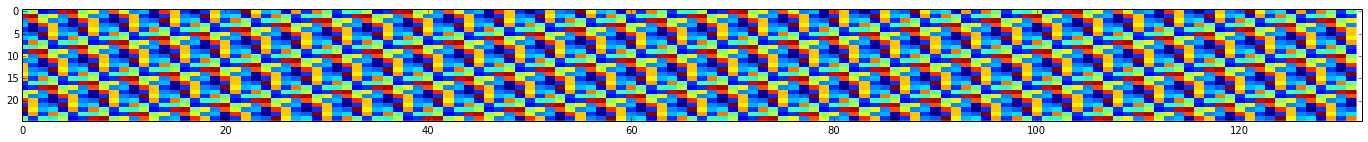

In [6]:
encoded = one_hot(vocab_size, batched_data)
plt.figure(figsize=(24,2))
plt.imshow(np.argmax(encoded, axis=2).T, aspect='auto', interpolation="none")
plt.xlim(0, encoded.shape[0])
plt.show()

minimum forward and backward computation example with the operators.

## The mathematical description of LSTM

Compared with the graphical representation, the equations leave no anbiguity and is easier to use as a reference.

Note: $h_t$ has the same dimension as the input vector $x_t$.

\begin{align}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
\tilde{C}_t &= \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) \\
C_t &= f_t * C_{t-1} + i_t * \tilde C_t \\
o_t &= \sigma(W_o [ h_{t-1}, x_t] + b_o) \\
h_t &= o_t * \tanh(C_t)
\end{align}

The convention for time-stamp is $h_{t-1} => h_t$, off by one compared with our RNN example.


In [7]:
class LSTM:
    
    def __init__(self, Wf, bf, Wi, bi, Wc, bc, Wo, bo):
        self.Wf = Wf
        self.bf = bf
        self.Wi = Wi
        self.bi = bi
        self.Wc = Wc
        self.bc = bc
        self.Wo = Wo
        self.bo = bo
        
    def chain(self, x_t, C_t_minus, h_t_minus):
        #input: x_t, C_t_minus, h_t_minus, 
        # return: C_t, h_t, 
        h_x_flow = edf.ConCat(h_t_minus, x_t)
        f_t = edf.Sigmoid(edf.Add(edf.VDot(h_x_flow, self.Wf), self.bf))
        i_t = edf.Sigmoid(edf.Add(edf.VDot(h_x_flow, self.Wi), self.bi))
        C_tilde = edf.Tanh(edf.Add(edf.VDot(h_x_flow, self.Wc), self.bc))
        C_t = edf.Add(edf.Mul(f_t, C_t_minus) , edf.Mul(i_t, C_tilde))
        o_t = edf.Sigmoid(edf.Add(edf.VDot(h_x_flow, self.Wo), self.bo))
        h_t = edf.Mul(o_t, edf.Tanh(C_t))

        return C_t, h_t

In [8]:
# single input, no batching.
def build_network(params, inputs, C0, h0):
    
    Wf, bf, Wi, bi, Wc, bc, Wo, bo, C2V, V2C = params
    
    input_len = inputs.shape[0]
    
    # clear edf.component graph
    edf.components = []
    
    # C and h are just plain python arrays
    C = [C0] + [None] * input_len
    h = [h0] + [None] * input_len
    preds = [None] * input_len
    
    loss = edf.Value(0)
    
    # instantiate network
    lstm = LSTM(Wf, bf, Wi, bi, Wc, bc, Wo, bo)
    
    # unfold the forward passage
    for t in range(input_len):
        
        current_char = edf.Value(inputs[t])
        
        char_vec = edf.VDot(current_char, C2V)
        
        C[t + 1], h[t + 1] = lstm.chain(char_vec, C[t], h[t])
        
        # find prediction before calculating score.
        # a better way is to compute score with the confidence level
        # in mind.
        
        pred = edf.SoftMax(edf.VDot(h[t + 1], V2C))
        
        preds[t] = pred
        
        log = edf.Log(edf.Sum(edf.Mul(pred, current_char))) # always over axis=-1
        
        loss = edf.Add(loss, edf.Mul(log, edf.Value(-1)))
        
    return preds, loss, C, h

In [9]:
# clear edf params graph
edf.params = []

# LSTM definition

Wf = edf.Param(edf.xavier((HIDDEN_SIZE * 2, HIDDEN_SIZE)))
bf = edf.Param(np.zeros((HIDDEN_SIZE)))

Wi = edf.Param(edf.xavier((HIDDEN_SIZE * 2, HIDDEN_SIZE)))
bi = edf.Param(np.zeros((HIDDEN_SIZE)))

Wc = edf.Param(edf.xavier((HIDDEN_SIZE * 2, HIDDEN_SIZE)))
bc = edf.Param(np.zeros((HIDDEN_SIZE)))

Wo = edf.Param(edf.xavier((HIDDEN_SIZE * 2, HIDDEN_SIZE)))
bo = edf.Param(np.zeros((HIDDEN_SIZE)))

# You also need a FC layer to project the character space into 
# the hiddel parameter space
C2V = edf.Param(np.random.random((vocab_size, HIDDEN_SIZE)))
V2C = edf.Param(np.random.random((HIDDEN_SIZE, vocab_size)))

# initialize with a zero vector.
C0 = edf.Value(np.zeros([HIDDEN_SIZE]))
h0 = edf.Value(np.zeros([HIDDEN_SIZE]))

losses = []

for batch in batched_data:
    # print(batch)
    inputs = one_hot(vocab_size, batch)
    
    preds, loss, C, h = build_network(edf.params, inputs, C0, h0)
    
    edf.Forward()
    
    C0 = edf.Value(C[-1].value)
    h0 = edf.Value(h[-1].value)
    
    edf.Backward(loss)
    
    output = "".join(list(map(lambda pred: ix_to_char[np.argmax(pred.value)], preds)
        ))    
    print(output, end='')
    losses.append(loss.value)
    edf.Adam(ETA)

法i法法i法法i法fi法  法法f iiiffii i法ff ii i 法i ii  i    法  ii      ii i ii   i  i   i        i      ii                                                                                                                                                                                     i                       i        iitl                 s  i        iitl            i  iis  is i     ittl    i       i  i题s  is i     iitli   i       i  i题s  is is    ittli   i       is有问题s  is is    ittlt  ii       is有i题s  is is    ittlt  ii       i没有题题！s is is    ittlt   i       没没有问题！. is is    ittle   x      输没没有有题！. is is   littlt  lx      输也没有题题！！his is   littlt  lx.    入输也没有问题！！his is   little fox. 中o 入没也没有问题！！his is   little fox. 中文输入法也没有问题！！his is   little fox. 中文输入法也没有问题！！his is   little fox. 中文 入法也没有问题！！his is   little fox. 中文 入法也没有问题！！his is a little fox. 中文输入法也没有问题！！his is a little fox. 中文输入法也没有问题！！his is a little fox. 中文输入法也没有问题！！his is a little fox. 中文输入输也没有问题！！his is a little fox. 中文输入输也没有问题！！his is a 

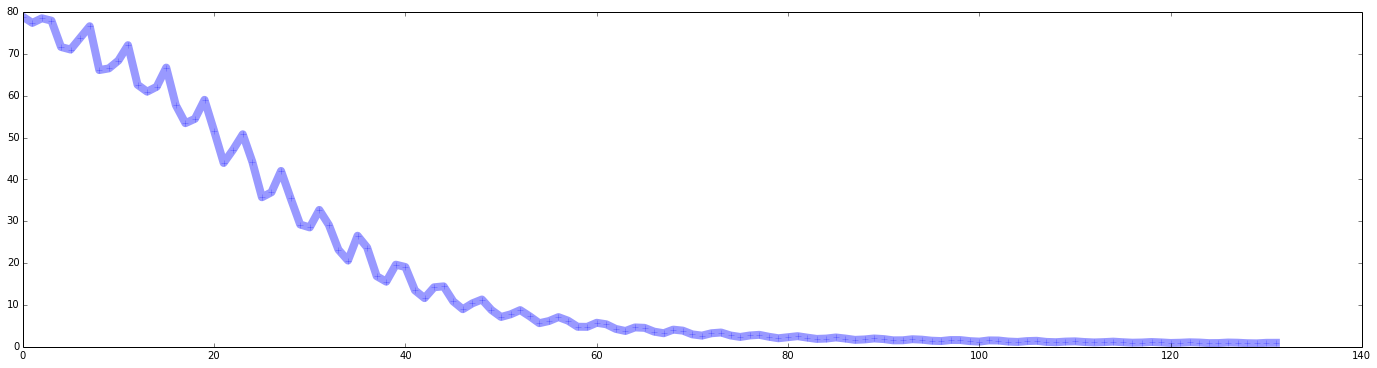

In [10]:
plt.figure(figsize=(24, 6))
plt.plot(losses, '+-', alpha=0.4, linewidth=8)

In [131]:
# hyperparameters
HIDDEN_SIZE = 65  # size of hidden layer of neurons
SEQ_LENGTH = 25  # number of steps to unroll the RNN for
ETA = 1e-3

In [135]:
# load full shakespear data
data = open('input.txt', 'r').read()  # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has {} characters, {} unique.'.format(data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [136]:
char_inds = np.array(list(map(lambda char: char_to_ix[char], data)))
tail = len(data) % SEQ_LENGTH
pad_length = SEQ_LENGTH - tail if tail else 0;

batched_data = np.append(char_inds, np.zeros(pad_length), axis=0)
batched_data.resize((int(len(data)/SEQ_LENGTH), SEQ_LENGTH))

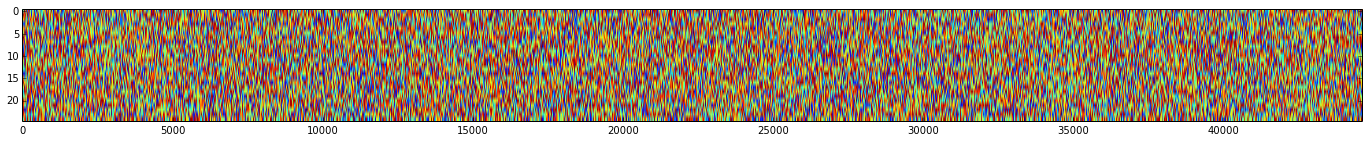

In [142]:
encoded = one_hot(vocab_size, batched_data)
plt.figure(figsize=(24,2))
plt.imshow(np.argmax(encoded, axis=2).T, aspect='auto')
plt.xlim(0, encoded.shape[0])
plt.show()

In [109]:
# clear edf params graph
edf.params = []

# LSTM definition

Wf = edf.Param(edf.xavier((HIDDEN_SIZE * 2, HIDDEN_SIZE)))
bf = edf.Param(np.zeros((HIDDEN_SIZE)))

Wi = edf.Param(edf.xavier((HIDDEN_SIZE * 2, HIDDEN_SIZE)))
bi = edf.Param(np.zeros((HIDDEN_SIZE)))

Wc = edf.Param(edf.xavier((HIDDEN_SIZE * 2, HIDDEN_SIZE)))
bc = edf.Param(np.zeros((HIDDEN_SIZE)))

Wo = edf.Param(edf.xavier((HIDDEN_SIZE * 2, HIDDEN_SIZE)))
bo = edf.Param(np.zeros((HIDDEN_SIZE)))

# You also need a FC layer to project the character space into 
# the hiddel parameter space
C2V = edf.Param(np.eye(vocab_size, HIDDEN_SIZE))
V2C = edf.Param(np.eye(HIDDEN_SIZE, vocab_size))

# initialize with a zero vector.
C0 = edf.Value(np.zeros([HIDDEN_SIZE]))
h0 = edf.Value(np.zeros([HIDDEN_SIZE]))

losses = []

for batch in batched_data:
    # print(batch)
    inputs = one_hot(vocab_size, batch)
    
    preds, loss, C, h = build_network(edf.params, inputs, C0, h0)
    
    edf.Forward()
    
    C0 = edf.Value(C[-1].value)
    h0 = edf.Value(h[-1].value)
    
    edf.Backward(loss)
    
    output = "".join(list(map(lambda pred: ix_to_char[np.argmax(pred.value)], preds)
        ))    
    print(output, end='')
    losses.append(loss.value)
    edf.Adam(ETA)

iHCCLTZI:Io!F::wT!bD!kTTTjj''FFFBZ.fZ!jD!cV!Fk-VZ.kjIkCSFKK
KKKiiyy:KKKK
-CSF: 
KKKiCCL-:I:oo!:::GcFkZ.Fk.jiSCIkkiJreeCsO Irkooksi:C:i ..i:k::jiC--::riiS:WrC:eJeeFeCrCceJeeFpprirClC:i:ioo:::rirClzaiiJZ ::fa::i
sSCS

i
sSiCCCaieoae:eddiioai reeeeeeeFpprii:: eeee:if:zaiCC ::if:


rirsiiCiiioo::::e:e seeiiiiiii:aa:s ie:eie   eereree   oos oi: erirr

sse:    ersiri:::rii::::::oree  i i:e o:::o iee iiiie ee:e:            


ereeeeeiii ee::::e  ire   eoe :iii eeee

rirei  iii ee:: e  re  rreee ee eeer riii eee    e e  riri       eer           iii i r ei               ie e                                                                                                                                                                                                                                                                                                                                                                                                                                            

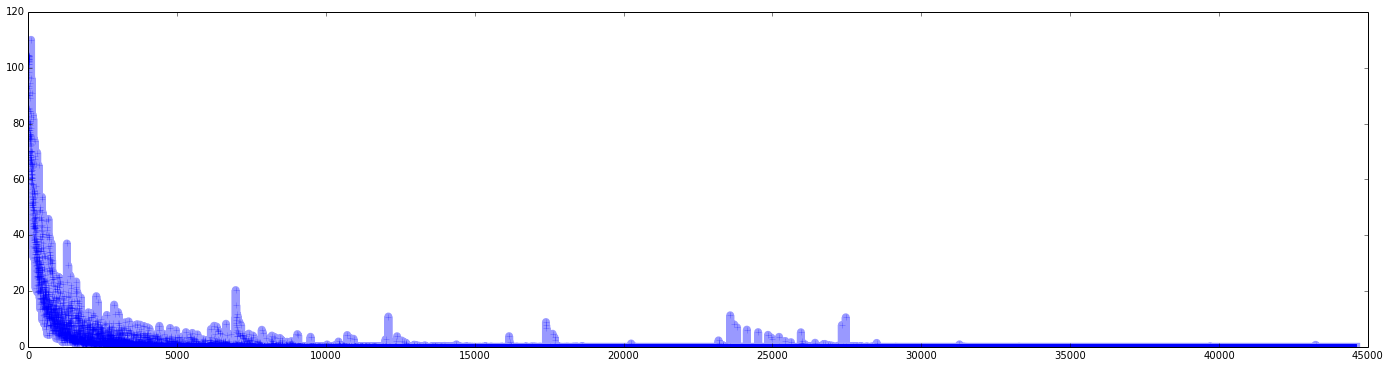

In [110]:
plt.figure(figsize=(24, 6))
plt.plot(losses, '+-', alpha=0.4, linewidth=8)